In [1]:
import socket
import msgpack
import open3d as o3d
# import trimesh
from IPython.display import display, Math
import numpy as np
import matplotlib.pyplot as plt
import time
import threading
import copy
import numba
import ipywidgets.widgets as widgets
import ipywidgets
from IPython.display import display

plt.style.use('seaborn-whitegrid')
%config InlineBackend.figure_format = 'retina'

# %autoawait off

# import asyncio
# # # !pip install nest-asyncio
# import nest_asyncio
# # nest_asyncio.apply()

###########################################

PI = np.pi
TWO_PI = 2*np.pi

# UDP header constant
UDP_TERMINATE = -1
UDP_RESET = 15
UDP_ROBOT_STATE_REPORT = 14
UDP_MOTOR_VEL_COMMEND = 13
UDP_MOTOR_POS_COMMEND = 12

from enum import IntEnum # to find which correspond to what
class UdpHeader(IntEnum):
    TERMINATE = UDP_TERMINATE
    RESET = UDP_RESET
    ROBOT_STATE_REPORT = UDP_ROBOT_STATE_REPORT
    MOTOR_SPEED_COMMEND = UDP_MOTOR_VEL_COMMEND
    MOTOR_POS_COMMEND = UDP_MOTOR_POS_COMMEND
    

ip_local = "127.0.0.1"
port_local = 32000

ip_remote = "127.0.0.1"
port_remote = 32001

BUFFER_LEN = 512  # in bytes

local_address = (ip_local, port_local)
remote_address = (ip_remote, port_remote)

packer = msgpack.Packer(use_single_float=True, use_bin_type=True)

REC_NAME = ("header", "T", "joint_pos", "joint_vel", "com_acc",
            "orientation","ang_vel", "actuation", "com_pos","com_vel")  # name of the returned state

ID_HEADER = 0
ID_T = 1 # simulation time
ID_JOINT_POS = 2 # joint angle
ID_JOINT_VEL = 3 # joint angular velocity
ID_COM_ACC = 4 # center of mass acceleration
ID_ORIENTATION = 5 # orientation of the body
ID_ANG_VEL = 6 # angular velocity of the body
ID_ACTUATION = 7 # actuation of the joint
ID_COM_POS = 8 # center of mass position
ID_COM_VEL = 9 # center of mass velocity

### Create a UDP socket

In [2]:
# https://adaickalavan.github.io/programming/udp-socket-programming-in-cpp-and-python/
# Python UDP Receiver
#Create a datagram socket
sock = socket.socket(socket.AF_INET, # Internet
                     socket.SOCK_DGRAM) # UDP
#Enable/disable immediate reuse of IP address
sock.setsockopt(socket.SOL_SOCKET,socket.SO_REUSEADDR,0)
#Set a timeout so the socket does not block indefinitely when trying to receive data
sock.settimeout(1)
#Bind the socket to the port
sock.bind(local_address)
# sock.connect(remote_address)

# for closing connection:
# sock.shutdown(socket.SHUT_RDWR) # shutdown the connection
# sock.close()# close the connection

### Start the simulation

In [11]:
# to start the simulation
import subprocess
import sys
# def run_simulation():
#     async def run_simulation_helfper():
#         return subprocess.Popen(["../build/flexipod.exe"])
#     asyncio.create_task(run_simulation_helfper())
# run_simulation()

## ref: https://stackoverflow.com/questions/16071866/non-blocking-subprocess-call
def run_simulation():
    subprocess.Popen(["../build/flexipod.exe"])
    task = time.sleep(1)
    return task

### test receiving udp packet

In [5]:
def test_udp_receive():
    s = time.perf_counter()
    try:
        data = sock.recv(BUFFER_LEN)
        data_unpacked = msgpack.unpackb(data)
        for n,d in zip(REC_NAME,data_unpacked):
            try:
                print(f'{n:<12s}:'+','.join(f'{k:>.3f}' for k in d))
            except:
                print(f'{n:<12s}:{d:>.3f}')

    except Exception as e:
        print(e)
        pass
    # sock.shutdown(socket.SHUT_RDWR) # shutdown the connection
    # sock.close()# close the connection
    elapsed = time.perf_counter() - s
    print(f"#--- executed in {elapsed*1000:0.2f} ms ---#")
    return data_unpacked
data = test_udp_receive()

header      :14.000
T           :15.016
joint_pos   :1.571,1.571,-1.571,-1.570
joint_vel   :0.000,-0.000,0.000,-0.000
com_acc     :0.000,-0.000,-0.006
orientation :1.000,-0.005,0.001,0.005,1.000,0.001
ang_vel     :-0.000,0.000,-0.000
actuation   :0.000,-0.001,0.000,-0.001
com_pos     :-0.000,0.000,0.144
com_vel     :-0.000,-0.000,-0.000
#--- executed in 0.45 ms ---#


### test sending udp packet

In [15]:
# sen_sock = initUDP(ip_remote, port_local) # socket that send udp packet

# data_send = [UDP_RESET,time.time(),[0,0,0,0]]
# data_send = [UDP_MOTOR_SPEED_COMMEND,time.time(),[2,2,-2,-2]]
data_send = [UDP_TERMINATE,time.time(),[0,0,0,0]]

# data_send = [0.5,0.0,1.0,2.0]
# data_send = [1,2,3,4]

# data_send = 20

data_send_packed = packer.pack(data_send) # https://msgpack-python.readthedocs.io/en/latest/api.html#msgpack.Packer
# data_send_packed = msgpack.packb(data_send)

num_bytes_send = sock.sendto(data_send_packed,remote_address)

print(data_send)
print(data_send_packed)

[-1, 1606020426.1136816, [0, 0, 0, 0]]
b'\x93\xff\xcaN\xbfs\xdb\x94\x00\x00\x00\x00'


In [6]:
w_max = round(650.0/60.0*np.pi*2)

pos_max = np.pi

# flag_start = True
# flag_should_send = False
# flag_reset = False

layout_b=ipywidgets.Layout(width='100px') # button layout
              
# stop button
button_stop = widgets.Button(
    description='stop',
    icon='stop',
    button_style='warning',
    layout=layout_b)


def OnClickButtonStop(b):
    global flag_start
    flag_start = False


button_stop.on_click(OnClickButtonStop)

# reset button
button_reset = widgets.Button(
    description='reset',
    icon='refresh',
    button_style='info',
    layout=layout_b)


def OnClickButtonReset(b):
    global flag_reset
    flag_reset = True


button_reset.on_click(OnClickButtonReset)


# restart button
button_restart = widgets.Button(
    description='restart',
    icon='refresh',
    button_style='warning',
    layout=layout_b)


def OnClickButtonRestart(b):
    OnClickButtonReset(b)
#     flag_start = True
    data_send = (UDP_RESET, time.time(), (0, 0, 0, 0))
    # https://msgpack-python.readthedocs.io/en/latest/api.html#msgpack.Packer
    data_send_packed = packer.pack(data_send)
    sock.sendto(data_send_packed, remote_address)


#     print("restarted")
button_restart.on_click(OnClickButtonRestart)

slider_layout = ipywidgets.Layout(width='200px')

JOINT_NAME = ("frontLeft", "backLeft", "frontRight", "backRight")
joint_vel_widgets = [
    widgets.FloatSlider(min=-w_max, max=w_max, step=.01, value=0,
                        continuous_update=False, description="",
                        disabled=True, layout=slider_layout) for n in JOINT_NAME]

joint_pos_widgets = [
    widgets.FloatSlider(min=-pos_max, max=pos_max, step=.01, value=0,
                        continuous_update=False, description="",
                        disabled=True, layout=slider_layout) for n in JOINT_NAME]
joint_labels = [
    widgets.Label(value=n) for n in JOINT_NAME]


for k, n in enumerate(JOINT_NAME):
    joint_vel_widgets[k].style.handle_color = 'red'
    joint_pos_widgets[k].style.handle_color = 'red'

control_slider_layout = ipywidgets.Layout(width='400px')

speed_widget = widgets.FloatSlider(min=-int(w_max/2.5), max=int(w_max/2.5), step=1, value=0.0,
                                   continuous_update=False, description="Speed", 
                                   layout=control_slider_layout)
speed_widget.style.description_width = '50px'

s_base_widget = widgets.FloatSlider(min=0.1, max=0.9, step=.02, value=0.6,
                                    continuous_update=False, description="s base", 
                                    layout=control_slider_layout)
s_base_widget.style.description_width = '50px'

s_offset_widget = widgets.FloatSlider(min=-0.1, max=0.1, step=.005, value=0,
                                      continuous_update=False, description="s offset", 
                                      layout=control_slider_layout,readout_format='.3f')
s_offset_widget.style.description_width = '50px'

gait_widget = widgets.ToggleButtons(
    options=[('rotate', 0), ('pace', 1), ('bound', 2), ('crawl', 3),('random',4)],
    description='gait:',
    disabled=False,
    button_style='',  # 'success', 'info', 'warning', 'danger' or ''
    tooltips=['rotation','pace gait', 'bounding gait', 'crawl','random movement'],
    #     icons=['check'] * 3
)
gait_widget.style.button_width = '70px'
gait_widget.style.description_width = '25px'

caption_name = list(REC_NAME[2:])+["speed"]
caption_list = [widgets.Label(value=f'{n}') for n in caption_name]
caption_title = [widgets.Label(value=f'{n}:') for n in caption_name]

caption_widget = widgets.HBox(
    [widgets.VBox(caption_title), widgets.VBox(caption_list)])

ui_vel_pos_widget = widgets.HBox([
    widgets.VBox([widgets.Label("")]+joint_labels),
    widgets.VBox([widgets.Label("joint vel [rad/s]")]+joint_vel_widgets),
    widgets.VBox([widgets.Label("joint pos [rad]")]+joint_pos_widgets)])

control_ui = widgets.VBox(
    (gait_widget, speed_widget, s_base_widget, s_offset_widget))

buttons_ui = widgets.HBox((button_stop, button_reset, button_restart))
buttons_ui.layout.align_items = 'flex-start'

app = widgets.VBox([ui_vel_pos_widget, caption_widget, control_ui, buttons_ui])
# display(app)

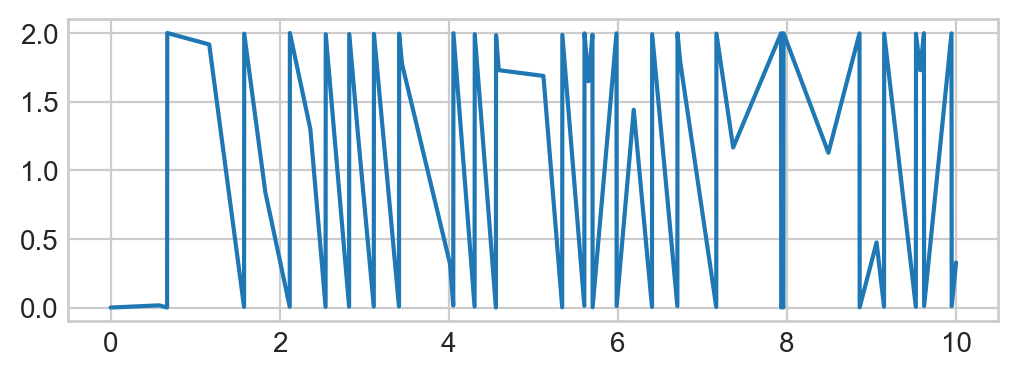

In [7]:
class RandomJointMotion():
    """
    generate a random joint motion
    """
    def __init__(this, w, t=0):
        this.t = t # time at current step
        this.t_switch = t
        this.wmax = np.abs(w)
        this.w = np.random.uniform(-this.wmax,this.wmax)
        this.pos = 0
        this.keepold=0.1
        this.keepnew=1-this.keepold 
    def UpdateStanceRatio(this,s):
        pass
    def GetPos(this, t,w=None,s=None):
        if w is not None:
            this.wmax = np.abs(w)
        dt = t - this.t # differenct in raw time
        this.t=t
        if t-this.t_switch>np.random.uniform(0.5,2):
            this.t_switch = t
            this.w = np.random.uniform(-this.wmax,this.wmax)
        this.pos = (this.pos+this.w*dt)%TWO_PI
        return this.pos
    def UpdateAngularVelocity(this,t,w):        
        this.wmax = w # TODO direction
        
random_gait = [ # rotate gait
    RandomJointMotion(0.1),# front left
    RandomJointMotion(0.1), # back left
    RandomJointMotion(0.1), # back right
    RandomJointMotion(0.1)] # front right

t_arr = np.linspace(0,10,5000)
w_arr = 8*PI*np.ones_like(t_arr)
s_arr = np.linspace(0.5,0.5,len(t_arr))

angles = [np.array([g.GetPos(t,w,s) for t,w,s in zip(t_arr,w_arr,s_arr)]) for g in random_gait]
plt.figure(figsize=(6,2),dpi=100)
plt.plot(t_arr,angles[0]/PI)
# for a in angles:
#     plt.plot(t_arr,a)

In [8]:
class WalkingTrot():
    """
  trotting gait
  @author: HonboZhu, BoxiXia
  """
    def __init__(this,
                 ot = 0, # normalized time offset [0-1], [unitless]
                 w = 0.1*np.pi, # average angular velocity [rad/s]
                 s = 0.5, # stance ratio = stance_time/cycle_time [unitless]
                 contact_angle = 120/180*PI, # contact_angle [rad]
                 p_stance_mid = 1.*np.pi,# angle at the middle of the stance phase [rad]
                 t =0, # time at current step
                ):
        this.ot = ot # normalized time offset [0-1], [unitless]
        assert(0<=this.ot<=1)
        this.w = w # average angular velocity [rad/s]
        this.c = contact_angle # contact_angle [rad]
#         this.contact_angle
        this.p_stance_mid = p_stance_mid       
        this.p_stance_low = p_stance_mid - this.c/2.0
        
        this.t = t # time at current step
        this.tc = this.ot # converted time [0-1,unitless]
        
        this.T = 2*np.pi/this.w # cycle time
        
        this.s = s # stance ratio = stance_time/cycle_time [unitless]
        this.ws = this.c/(this.s) # w_stance, (time normalized) average angular velocity of stance phase [rad]
        this.wa = (TWO_PI-this.c)/(1-this.s) # w_air, (time normalized) average angular velocity of air phase [rad]
        
        this.p_stance_high = p_stance_mid + this.c/2.0
        print(np.rad2deg(this.p_stance_low),np.rad2deg(p_stance_mid),np.rad2deg(this.p_stance_high))
        
        # get the initial position
        if this.ot<this.s: # if normalized time offset < stance ratio
            this.pos = this.p_stance_low + this.c/this.s*this.ot
        else:
            this.pos = this.p_stance_low + this.c + (TWO_PI-this.c)/(1-this.s)*(this.ot-this.s)
        
#     @njit
#     def UpdateStanceRatio(this,s):
#         """
#         update the stance ratio s (=: stance_time/cycle_time [unitless])
#         """
#         ws = this.c/(s) # w_stance, (time normalized) average angular velocity of stance phase [rad]
#         wa = (TWO_PI-this.c)/(1-s) # w_air, (time normalized) average angular velocity of air phase [rad]
#         # update the converted (normalized) time this.tc
        
#         pos_raw = (this.pos -this.p_stance_low)%TWO_PI
#         if pos_raw<0:
#             pos_raw+=TWO_PI # convert to 0-2PI
#         if pos_raw<this.c:
#             this.tc = pos_raw/ws
#         else:
#             this.tc = (pos_raw-this.c)/wa+s
            
#         this.s = s # stance ratio = stance_time/cycle_time [unitless]
#         this.ws = ws
#         this.wa = wa

    def UpdateStanceRatio(this,s):
        """
        update the stance ratio s (=: stance_time/cycle_time [unitless])
        """
        ws = this.c/(s) # w_stance, (time normalized) average angular velocity of stance phase [rad]
        wa = (TWO_PI-this.c)/(1-s) # w_air, (time normalized) average angular velocity of air phase [rad]
        # update the converted (normalized) time this.tc
        
        this.s = s # stance ratio = stance_time/cycle_time [unitless]
        this.ws = ws
        this.wa = wa
        
        if this.tc<this.s: # 0-s
            this.pos = (this.p_stance_low + this.ws*this.tc)%TWO_PI
        else: # s-1
            this.pos = (this.p_stance_low + this.c+this.wa*(this.tc-this.s))%TWO_PI
            


    def GetPos(this, t,w=None,s=None):
        """
        return the position [0,2pi] [rad] given the current time [s]
        """
        if w is not None:
            this.w = w
        if (s is not None) and s!=this.s:
            this.UpdateStanceRatio(s)
        dt = t - this.t # differenct in raw time
        this.t = t
        dnt = this.w*dt/TWO_PI # normalized phase difference [0-1][unitless]
        this.tc = (this.tc + dnt)%1.0 # # current converted time [0-1,unitless]
        
        # todo sign
        if this.tc<this.s: # 0-s
            this.pos = (this.p_stance_low + this.ws*this.tc)%TWO_PI
        else: # s-1
            this.pos = (this.p_stance_low + this.c+this.wa*(this.tc-this.s))%TWO_PI
        return this.pos

    def UpdateAngularVelocity(this,t,w):        
        this.w = w # TODO direction
    

    

    
    
    
rotation_gait = [ # rotate gait
    WalkingTrot(0,p_stance_mid = 1./2.*np.pi,contact_angle = 145/180*PI),# front left
    WalkingTrot(0,p_stance_mid = 1./2.*np.pi,contact_angle = 145/180*PI), # back left
    WalkingTrot(0.5,p_stance_mid = -1./2.*np.pi,contact_angle = 145/180*PI), # back right
    WalkingTrot(0.5,p_stance_mid = -1./2.*np.pi,contact_angle = 145/180*PI)] # front right

pace_gait = [ # pace gait
    WalkingTrot(0,p_stance_mid = 1./2.*np.pi,contact_angle = 145/180*PI),# front left
    WalkingTrot(0,p_stance_mid = 1./2.*np.pi,contact_angle = 145/180*PI), # back left
    WalkingTrot(0.5,p_stance_mid = 1./2.*np.pi,contact_angle = 145/180*PI), # back right
    WalkingTrot(0.5,p_stance_mid = 1./2.*np.pi,contact_angle = 145/180*PI)] # front right

bounding_gait = [ # bounding gait
    WalkingTrot(0,p_stance_mid = 1./2.*np.pi,contact_angle = 145/180*PI),# front left
    WalkingTrot(0.5,p_stance_mid = 1./2.*np.pi,contact_angle = 145/180*PI), # back left
    WalkingTrot(0.5,p_stance_mid = 1./2.*np.pi,contact_angle = 145/180*PI), # back right
    WalkingTrot(0,p_stance_mid = 1./2.*np.pi,contact_angle = 145/180*PI) # front right
]

crawl_gait = [ # crawl gait #2
    WalkingTrot(0,p_stance_mid = 1./2.*np.pi,contact_angle = 145/180*PI),# front left
    WalkingTrot(0.75,p_stance_mid = 1./2.*np.pi,contact_angle = 145/180*PI), # back left
    WalkingTrot(0.25,p_stance_mid = 1./2.*np.pi,contact_angle = 145/180*PI), # back right
    WalkingTrot(0.5,p_stance_mid = 1./2.*np.pi,contact_angle = 145/180*PI) # front right
]

gaits = [rotation_gait,pace_gait,bounding_gait,crawl_gait,random_gait]



# gaits = [ # trotting gait #2 alternate gait
#     WalkingTrot(0,p_stance_mid = 1./2.*np.pi,contact_angle = 145/180*PI),# front left
#     WalkingTrot(0.7,p_stance_mid = 1./2.*np.pi,contact_angle = 145/180*PI), # back left
#     WalkingTrot(0,p_stance_mid = 1./2.*np.pi,contact_angle = 145/180*PI), # back right
#     WalkingTrot(0.7,p_stance_mid = 1./2.*np.pi,contact_angle = 145/180*PI)] # front right

# gaits = [ # bounding gait
#     WalkingTrot(0,p_stance_mid = 1./2.*np.pi,contact_angle = 160/180*PI),# front left
#     WalkingTrot(0.4,p_stance_mid = 1./2.*np.pi,contact_angle = 160/180*PI), # back left
#     WalkingTrot(0.4,p_stance_mid = 1./2.*np.pi,contact_angle = 160/180*PI), # back right
#     WalkingTrot(0,p_stance_mid = 1./2.*np.pi,contact_angle = 160/180*PI) # front right
# ]



# gaits = [ # bounding gait same phase
#     WalkingTrot(0,p_stance_mid = 1./2.*np.pi,contact_angle = 180/180*PI),# front left
#     WalkingTrot(0.20,p_stance_mid = 1./2.*np.pi,contact_angle = 180/180*PI), # back left
#     WalkingTrot(0.20,p_stance_mid = 1./2.*np.pi,contact_angle = 180/180*PI), # back right
#     WalkingTrot(0,p_stance_mid = 1./2.*np.pi,contact_angle = 180/180*PI) # front right
# ]

# gaits = [ # bounding gait same phase
#     WalkingTrot(0,p_stance_mid = 1./2.*np.pi,contact_angle = 180/180*PI),# front left
#     WalkingTrot(0,p_stance_mid = 1./2.*np.pi,contact_angle = 180/180*PI), # back left
#     WalkingTrot(0,p_stance_mid = 1./2.*np.pi,contact_angle = 180/180*PI), # back right
#     WalkingTrot(0,p_stance_mid = 1./2.*np.pi,contact_angle = 180/180*PI) # front right
# ]


# t_arr = np.linspace(0,4,1000)
# w_arr = PI*np.ones_like(t_arr)
# s_arr = np.linspace(0.5,0.5,1000)
# # w_arr[300:] = -2*PI

# # w_arr = np.linspace(0,2*TWO_PI,1000)


# angle1 = np.array([gaits[0].GetPos(t,w,s) for t,w,s in zip(t_arr,w_arr,s_arr)])
# angle2 = np.array([gaits[1].GetPos(t,w,s) for t,w,s in zip(t_arr,w_arr,s_arr)])
# angle3 = np.array([gaits[2].GetPos(t,w,s) for t,w,s in zip(t_arr,w_arr,s_arr)])
# angle4 = np.array([gaits[3].GetPos(t,w,s) for t,w,s in zip(t_arr,w_arr,s_arr)])

# # angle3 = 2*np.pi-angle1
# # angle4 = 2*np.pi-angle2
# # motor_pos = np.stack((angle1,angle2,angle3,angle4),axis=1)

# # vel1 = np.array([trot.GetVel(phase) for phase in t_arr])
# # vel2 = np.array([trot.GetVel(phase+0.5) for phase in t_arr])
# # vel3= -vel1
# # vel4= -vel2
# # motor_vel = np.stack((vel1,vel2,vel3,vel4),axis=1)

# plt.figure(figsize=(4,2),dpi=300)
# plt.plot(t_arr+0.01,np.rad2deg(angle1)+5,',-',markersize=0.5,linewidth=0.5,alpha=0.9,label='front left')
# plt.plot(t_arr,np.rad2deg(angle2),',-',markersize=0.5,linewidth=0.5,alpha=0.9,label='back left')
# plt.plot(t_arr+0.01,np.rad2deg(angle3)+5,',-',markersize=0.5,linewidth=0.5,alpha=0.9,label='back right')
# plt.plot(t_arr,np.rad2deg(angle4),',-',markersize=0.5,linewidth=0.5,alpha=0.9,label='front right')

# plt.yticks(np.arange(0, 360+45, 45))

# plt.ylabel("motor pos [deg]")
# plt.xlabel("time [s]")
# plt.legend()
# plt.show()

17.499999999999993 90.0 162.50000000000003
17.499999999999993 90.0 162.50000000000003
-162.50000000000003 -90.0 -17.499999999999993
-162.50000000000003 -90.0 -17.499999999999993
17.499999999999993 90.0 162.50000000000003
17.499999999999993 90.0 162.50000000000003
17.499999999999993 90.0 162.50000000000003
17.499999999999993 90.0 162.50000000000003
17.499999999999993 90.0 162.50000000000003
17.499999999999993 90.0 162.50000000000003
17.499999999999993 90.0 162.50000000000003
17.499999999999993 90.0 162.50000000000003
17.499999999999993 90.0 162.50000000000003
17.499999999999993 90.0 162.50000000000003
17.499999999999993 90.0 162.50000000000003
17.499999999999993 90.0 162.50000000000003


In [17]:
from IPython.display import display
from IPython.core.display import HTML

display(HTML("<style>textarea, input { font-family: monospace; }</style>"))


control_update_interval = 1/200.
display_update_interval = 1/20.

speed_update_interval = 2.0

def flush_socket():
    """flush out the oldest data in socket buffer"""
    sock.settimeout(1/1000.)
    for k in range(1000):
        try:
            data_receive= sock.recv(BUFFER_LEN)
        except socket.timeout:
            break
#     print(k)
    sock.settimeout(1)

def AppControl():
    time_previous = 0
    display_timer = 0
    speed_timer = 0
    speed = 0.0 # speed of the robot
    previous_pos = np.array((0.,0.,0.))
    
    global joint_vel_widgets
    global flag_start
    global flag_reset
    flag_reset = False
    flag_start=True
    new_receive = False
    
    s_offset = 0.5
    s_base = 0.5
    
    pos_cmd  = np.zeros(4,dtype=np.float64) # joint positions command 
    vel_cmd  = np.zeros(4,dtype=np.float64) # joint velocities command

    # previously commanded joint velocity
    joint_vel_prev = np.asarray((w.value for w in joint_vel_widgets))
    
    # reset the speed
    speed_widget.value = 0
    desired_speed = 0
    gait_id = 0
    
    flush_socket()
    while flag_start:
        try:
            data_receive= sock.recv(BUFFER_LEN)
            data_receive_unpacked = msgpack.unpackb(data_receive)
            new_receive = True
            time_now = data_receive_unpacked[ID_T]
        except socket.timeout:
#             print("rec_socket timed out!\r",end='')
            pass

#         time_now = time.time()
#         display(time_now)
        motor_pos_meas = np.asarray(data_receive_unpacked[ID_JOINT_POS])
        # assumming motor_pos_meas is in [-pi,pi]

        for k in range(4):
#                 joint_vel_widgets[k].value = 10.0*motor_vel_cmd[k]
            pos = gaits[gait_id][k].GetPos(time_now)
    
            if desired_speed==0:
                pos = np.pi/2# set to standing position
                
            if gait_id>0 and k>=2:
                pos = TWO_PI- pos 
            if pos>PI:
                pos=pos-TWO_PI      
            pos_cmd[k] = pos

            pos_error = pos - motor_pos_meas[k]

            if pos_error>PI:
                pos_error =-TWO_PI+pos_error
            elif pos_error<-PI:
                pos_error = TWO_PI+pos_error

            if abs(desired_speed)<1:
                 vel_cmd[k] = (5+abs(desired_speed))*pos_error
            else:
                vel_cmd[k] = 30*pos_error
                
        if time_now - display_timer>display_update_interval:
            display_timer = time_now
            if flag_reset:
                flag_reset = False
                speed_widget.value = 0
                
            # update speed every 3m travelled
            pos = np.asarray(data_receive_unpacked[ID_COM_POS])
            dist = np.linalg.norm((pos- previous_pos)[:2])
            if dist>3:
                speed = dist/(time_now - speed_timer)
                speed_timer = time_now
                previous_pos = pos
                caption_list[-1].value = f"{speed:<12.3f}"    
            # update speed every speed_update_interval
            if time_now - speed_timer> speed_update_interval:
                speed_timer = time_now
                pos = np.asarray(data_receive_unpacked[ID_COM_POS])
                speed = np.linalg.norm((pos- previous_pos)[:2])/speed_update_interval
                previous_pos = pos
                caption_list[-1].value = f"{speed:<12.3f}"

            desired_speed = speed_widget.value
            
            gait_id = gait_widget.value
            for k in range(4):
                joint_pos_widgets[k].value = pos_cmd[k]
                joint_vel_widgets[k].value = vel_cmd[k]
#                 if k==0 or k==3:
                gaits[gait_id][k].UpdateAngularVelocity(time_now,desired_speed)
#                 else:
#                     gaits[k].UpdateAngularVelocity(time_now,0.5*desired_speed)
                
            if (s_offset!=s_offset_widget.value) or (s_base!=s_base_widget.value):
                s_offset = s_offset_widget.value
                s_base = s_base_widget.value
                for k in range(4):
                    if k<=2:
                        gaits[gait_id][k].UpdateStanceRatio(s_base-s_offset)
                    else:
                        gaits[gait_id][k].UpdateStanceRatio(s_base+s_offset)

            # data checking the header should be a certain number(TODO)
            if new_receive:
                new_receive = False
                for k,caption in enumerate(caption_list[:-1]):
                    caption.value = "  ".join(f"{x:<9.3f}" for x in data_receive_unpacked[2+k])            
        
        # send data
        data_send = (UDP_MOTOR_VEL_COMMEND,time_now,vel_cmd.tolist())
#             display(data_send)
        data_send_packed = packer.pack(data_send) # https://msgpack-python.readthedocs.io/en/latest/api.html#msgpack.Packer
        sock.sendto(data_send_packed,remote_address)
#             print(f"{np.fmod(time_now,1.0)*100}\r",end='') 
    print("exit")

    
run_simulation()

control_thread = threading.Thread(target=AppControl)
display(app)
control_thread.start()

exit


<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

In [9]:
# while
# try:
#     data_receive= sock.recv(BUFFER_LEN)
#     data_receive_unpacked = msgpack.unpackb(data_receive)
#     new_receive = True
#     time_now = data_receive_unpacked[ID_T]

action = (1,1,-1,-1)

data_send = (UDP_MOTOR_VEL_COMMEND,time.time(),action)
# display(data_send)
data_send_packed = packer.pack(data_send) # https://msgpack-python.readthedocs.io/en/latest/api.html#msgpack.Packer
sock.sendto(data_send_packed,remote_address)

_=test_udp_receive()

header      :14.000
T           :682.542
joint_pos   :1.574,1.573,1.481,1.554
joint_vel   :0.000,-0.001,-0.003,-0.000
com_acc     :-0.005,-0.002,-0.001
orientation :1.000,0.002,-0.000,-0.001,0.899,0.437
actuation   :-0.004,0.003,0.000,-0.000
com_pos     :0.004,-0.005,0.066
com_vel     :0.000,-0.000,0.000
#--- executed in 2.00 ms ---#


## rotation

In [ ]:
from scipy.spatial.transform import Rotation as R
def RotateFromVec(vec, angle):
    vec = np.asarray(vec, dtype=np.float64)
    vec_norm = np.linalg.norm(vec)
    if vec_norm != 1:
        vec = vec/vec_norm
    vec *= angle
    h = np.eye(4)
    h[:3, :3] = R.from_rotvec(vec).as_dcm()
    return h       

# https://www.euclideanspace.com/maths/geometry/rotations/conversions/matrixToQuaternion/
def RotMatrixToQuarternion(m):
    """
    m is a 3x3 rotation matrix or 4x4 homogenious transformation matrix
    """
    w = np.sqrt(1+m[0,0]+m[1,1]+m[2,2])/2.0
    w4 = 4*w
    x = (m[2,1]-m[1,2])/w4
    y = (m[0,2]-m[2,0])/w4
    z = (m[1,0]-m[0,1])/w4
    return np.array([w,x,y,z])

# https://www.euclideanspace.com/maths/geometry/rotations/conversions/quaternionToAngle/index.htm
def QuarternionToAxisAngle(q):
    if(q[0]>1):
        q = q/np.linalg.norm(q)
    angle = 2.0 * np.arccos(q[0])
    s = np.sqrt(1-q[0]**2)
    if(s<1e-8):
        return q[1:],angle
    else:
        return q[1:]/s,angle

In [ ]:
m = RotateFromVec([0,1,1],np.pi/2.)
q = RotMatrixToQuarternion(m)
QuarternionToAxisAngle(q)

In [ ]:
def angle(x):
    return x- (x//np.pi)*(2*np.pi)

def angle2(x):
    if x<-np.pi:
        return x+np.pi*2
    elif x<np.pi:
        return x
    else:
        return x-np.pi*2
angle2 = np.vectorize(angle2)

In [ ]:
x = np.linspace(-2*np.pi,2*np.pi,1001)
y1 = angle(x)
y2 = angle2(x)

plt.plot(x/np.pi,y1/np.pi)
plt.plot(x/np.pi,y2/np.pi)

In [ ]:
import time
import asyncio

async def say_after(delay, what):
    await asyncio.sleep(delay)
    print(what)

async def test():
    print(f"started at {time.strftime('%X')}")

    await say_after(1, 'hello')
    await say_after(2, 'world')

    print(f"finished at {time.strftime('%X')}")

await test()

In [ ]:
task = asyncio.create_task(test())
print("this is reached")